In [1]:
#텐서플로우 모듈
import tensorflow as tf
#행렬 계산 모듈
import numpy as np
#이미지 변환 모듈
import scipy.misc
#이미지 출력 모듈
import matplotlib.pyplot as plt
#png 이미지 파일 부르는 모듈
import imageio
#다수의 파일을 부르는 모듈
import glob
#학습 데이터 입력 모듈
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/",one_hot=True)
tf.reset_default_graph()

C:\Users\Iris\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
#입력 데이터 값 - 데이터 개수(미정),28*28, 색상은 1개
X=tf.placeholder(tf.float32, [None,28,28,1])
#출력 데이터 값 - 데이터 개수(미정), 출력값 10(숫자의 개수)
Y=tf.placeholder(tf.float32, [None,10])
#드롭아웃을 위한 변수
keep_prob=tf.placeholder(tf.float32)

In [3]:
#1차 컨볼루션 계층 형성

#첫번째 계층의 가중치
#3*3 크기의 커널을 가지고, 입력 커널은 1개, 32개의 출력 커널, 표준편차는 0.01인 랜덤변수로 초기화
W1=tf.Variable(tf.random_normal([3,3,1,32],stddev=0.01))
#컨볼루션 계층 형성 -  1개의 batch, 오른쪽으로 1칸, 아래로 한칸 움직이는 윈도우에 색은 1개 - 가장자리를 포함하기위해 패딩을 해줌
L1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
#활성화 함수 relu
L1=tf.nn.relu(L1)

#1차 풀링 계층 형성

#1개의 batch, 두칸씩 움직여서 풀링계층 형성, 색은 1개 역시나 패딩 - 두칸씩 움직이므로 14*14 32개
L1 = tf.nn.max_pool(L1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [4]:
#2차 컨볼루션 계층 형성

#두번째 계층의 가중치
#3*3 크기의 커널을 가지고, 입력 커널은 32개, 64개의 출력커널, 표준편차는 0.01인 랜덤변수로 초기화
W2=tf.Variable(tf.random_normal([3,3,32,64],stddev=0.01))
#위 계층과 같음
L2=tf.nn.conv2d(L1,W2,strides=[1,1,1,1], padding='SAME')
L2=tf.nn.relu(L2)

#2차 풀링 계층 형성

#위 계층과 같음 - 7*7 풀링 64개
L2=tf.nn.max_pool(L2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [5]:
#만들어진 특징을 통해 10개의 아웃풋을 만들어내는 완전 연결 계층

#7*7 개의 풀링 계층 64개 * 256 크기의 행렬로 초기화
W3=tf.Variable(tf.random_normal([7*7*64,256],stddev=0.01))
#출력계층의 행의 크기가 1*10 이므로 1 * (7*7*64) 크기의 행렬로 L2를 재구성
L3=tf.reshape(L2, [-1,7*7*64])
#재구성한 L2와 초기화한 W3를 곱해줌 - 1*256 크기의 출력
L3=tf.matmul(L3,W3)
#활성화함수 relu
L3=tf.nn.relu(L3)
#오버피팅 방지를 위한 드롭아웃
L3=tf.nn.dropout(L3,keep_prob)

#1*10의 출력을 내기 위해 W4를 256*10으로 초기화 후 L3*W4=1*10의 행렬 출력
W4=tf.Variable(tf.random_normal([256,10],stddev=0.01))
model = tf.matmul(L3,W4)

In [6]:
#최적화 함수

#Y를 목표로 model 손실함수(얼마나 목표값과 차이가 나는지 - 예측값과 실제값 사이의 확률 분포 차이를 계산)
#그리고 그 각각의 값들을 softmax 함수로 총 합이 1이 되게 확률화
#그 이후 한 행을 전부 더한 후 차원을 하나 줄여 평균을 낸다
#이 손실(cost)를 최적화 함수 Adamoptimizer를 학습률 0.001로 최소화 하는 방향으로 최적화
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
optimizer=tf.train.AdamOptimizer(0.001).minimize(cost)

In [7]:
#전역변수 초기화
init=tf.global_variables_initializer()
#세션 생성
sess=tf.Session()
saver=tf.train.Saver(tf.global_variables())

ckpt=tf.train.get_checkpoint_state('./model')
#체크포인트 있으면 불러오기
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess,ckpt.model_checkpoint_path)
#체크포인트 없으면 초기화
else:
    sess.run(init)


INFO:tensorflow:Restoring parameters from ./model\cnn.ckpt


In [16]:
#학습

#일괄 처리 데이터량 100
batch_size=100
#일괄 처리 횟수 = 총 데이터 개수 / 일괄 처리 데이터량
total_batch=int(mnist.train.num_examples/batch_size)

#15번 반복 학습 한다
for epoch in range(15):
    #총 코스트 초기화
    total_cost=0
    #일괄 처리 횟수만큼 반복
    for i in range(total_batch):
        #일괄 처리 크기만큼 데이터 선언 - 배치 데이터를 인풋값에 맞게 재구성
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs=batch_xs.reshape(-1,28,28,1)
        #드롭아웃 계수 0.8을 주고 최적화
        _, cost_val=sess.run([optimizer,cost],
                            feed_dict={X:batch_xs,Y:batch_ys, keep_prob:0.8})
        #총 손실량 계산
        total_cost+=cost_val
    print('Epoch:', '%04d' %(epoch+1),
         'Avg. cost = ', '{:.3f}'.format(total_cost/total_batch))
print('operation end')
#saver.save(sess, './model/cnn.ckpt')

Epoch: 0001 Avg. cost =  0.344
Epoch: 0002 Avg. cost =  0.101
Epoch: 0003 Avg. cost =  0.071
Epoch: 0004 Avg. cost =  0.056
Epoch: 0005 Avg. cost =  0.045
Epoch: 0006 Avg. cost =  0.037
Epoch: 0007 Avg. cost =  0.031
Epoch: 0008 Avg. cost =  0.028
Epoch: 0009 Avg. cost =  0.023
Epoch: 0010 Avg. cost =  0.021
Epoch: 0011 Avg. cost =  0.019
Epoch: 0012 Avg. cost =  0.016
Epoch: 0013 Avg. cost =  0.014
Epoch: 0014 Avg. cost =  0.013
Epoch: 0015 Avg. cost =  0.013
operation end


'./model/cnn.ckpt'

In [17]:
#정확도 측정

#모델이 말한 값과 원래 값이 같으면 1
is_correct = tf.equal(tf.argmax(model,1),tf.argmax(Y,1))
#평균을 내어 몇퍼센트인지 확인
accuracy=tf.reduce_mean(tf.cast(is_correct,tf.float32))
#테스트 데이터값도 인풋값에 맞게 재구성
#실제 실험할때는 드롭아웃을 하지 않으므로 1로
print('정확도:',sess.run(accuracy, feed_dict={X:mnist.test.images.reshape(-1,28,28,1), Y:mnist.test.labels, keep_prob:1}))

정확도: 0.9908


C:\Users\Iris\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


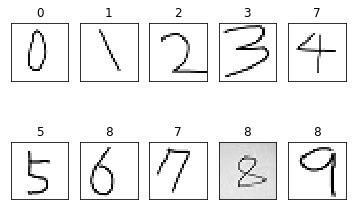

In [8]:
#직접 그려서 실험

our_own_dataset = []
for image_file_name in glob.glob('my_own_images/2828_my_own_?.png'):
    
    #이미지 파일을 array에 넣는다
    img_array = scipy.misc.imread(image_file_name,flatten=True)
    
    #이미지 파일을 28*28 픽셀로 재구성한다
    img_data = 255 - img_array.reshape(784)
    
    #record를 학습 데이터 리스트에 붙힌다
    our_own_dataset.append(img_data)
mydata=np.array(our_own_dataset)
#result = sess.run(tf.argmax(model,1), feed_dict={X: our_own_dataset,keep_prob:1})
#이미지 출력과 정답이 맞는지 동시에 출력해서 확인
labels = sess.run(model,
                 feed_dict={X:mydata.reshape(-1,28,28,1),
                           keep_prob:1})
#이미지 피규어 클래스 생성
fig = plt.figure()

for i in range(10):
    subplot=fig.add_subplot(2,5,i+1)
    
    #이미지에 대해서 선명하게 보기위해 x축과 y축 삭제
    subplot.set_xticks([])
    subplot.set_yticks([])
    
    #신경망이 내놓은 정답 표기
    subplot.set_title('%d' %np.argmax(labels[i]))
    #이미지 출력
    subplot.imshow(our_own_dataset[i].reshape((28,28)),
                  cmap=plt.cm.gray_r)
plt.show()